# PyTorch Deep Neural Networks
## Chris Tralie



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from scipy import signal

# Torch Data Loader for 2D Blobs

We'll now create a dataset which is not linearly separable.  We'll be careful that the dataset has roughly as many positive examples as negative examples

In [2]:
class Blobs(Dataset):
    def __init__(self, n_samples, dim, r):
        """
        Parameters
        ----------
        n_samples: int
            The number of data points in the dataset
        dim: int
            Dimension of each point
        r: float
            The negative class is inside of this radius
        """
        self.n_samples = n_samples
        self.dim = dim
        self.r = r
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        """
        Return a tuple (x, y)
        """
        theta = np.random.rand()*2*np.pi
        r = 2*self.r*np.random.rand()
        x = np.array([r*np.cos(theta), r*np.sin(theta)])
        y = 1
        if r < self.r:
            y = 0
        x = torch.from_numpy(np.array(x, dtype=np.float32))
        y = torch.from_numpy(np.array(y, dtype=np.float32))
        return x, y

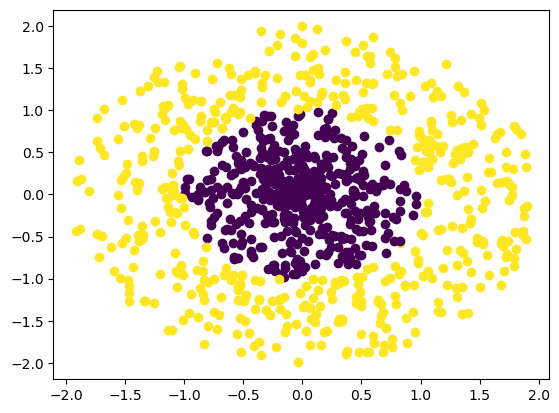

In [3]:
n_samples = 1000
data = Blobs(n_samples, dim=2, r=1)
for i in range(len(data)):
    x, y = data[i]
    plt.scatter(x[0], x[1], c=y, vmin=0, vmax=1)


## Data Loaders / Mini-Batch Gradient Descent

X.shape torch.Size([16, 2])
Y.shape torch.Size([16])


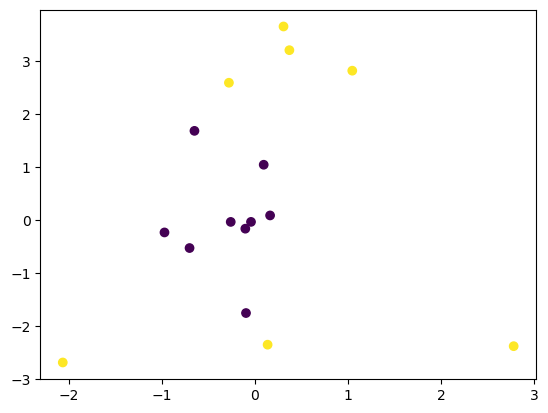

In [4]:
n_samples = 1000
dim = 2
offset = 2
## Step 1: Gather data
data = Blobs(n_samples, dim, 2)

loader = DataLoader(data, batch_size=16, shuffle=True)
X, Y = next(iter(loader))
print("X.shape", X.shape)
print("Y.shape", Y.shape)
plt.scatter(X[:, 0], X[:, 1], c=Y)

## PyTorch Training Loop

In [10]:
print(model)
N = 0
for p in model.parameters():
    print(p)
    N += len(p)
print(N)

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=2, bias=True)
  (5): ReLU()
  (6): Linear(in_features=2, out_features=1, bias=True)
)
Parameter containing:
tensor([[-1.0296,  0.2720],
        [ 0.3587, -0.1059],
        [-0.0097,  0.0311],
        [ 0.2746, -0.9369],
        [ 0.7683,  0.7384]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0521,  0.9851, -0.1929,  0.0383, -0.0071], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([[-0.4673,  0.3165,  0.0616, -0.5490, -0.5887],
        [-0.4416,  0.2062,  0.2809, -0.5426, -0.4978],
        [ 0.8888,  0.2230, -0.1938,  1.2059,  1.0420],
        [-0.5518,  0.0797,  0.0275, -0.5415, -0.4975]], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([ 1.0559,  0.9950, -0.3023,  1.2158], device='cuda:0',
       requires_grad=True)
Pa

In [6]:
# Try to use the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print("Device: ", device)

## Step 2: Create sequential neural net model (setup a function space)

# 100 neurons in the first layer
layer1 = nn.Linear(2, 5)
layer1 = layer1.to(device)
relu1 = nn.ReLU()
relu1 = relu1.to(device)

# 4 neurons in the second layer
layer2 = nn.Linear(5, 4)
layer2 = layer2.to(device)
relu2 = nn.ReLU()
relu2 = relu2.to(device)

layer3 = nn.Linear(4, 2)
layer3 = layer3.to(device)
relu3 = nn.ReLU()
relu3 = relu3.to(device)

# 1 neuron in the last layer
layer4 = nn.Linear(2, 1)
layer4 = layer4.to(device)

model = nn.Sequential(layer1, relu1, layer2, relu2, layer3, relu3, layer4)

# Output of layer 3 will go through a logistic function

## Step 3: Setup the loss function
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 200 # Each "epoch" is a loop through the entire dataset
# and we use this to update the parameters
losses = []
accuracy = []
for epoch in range(n_epochs):
    print(".", end="")
    loader = DataLoader(data, batch_size=16, shuffle=True)
    for X, Y in loader: # Go through each mini batch
        # Move inputs/outputs to GPU
        X = X.to(device)
        Y = Y.to(device)
        # Reset the optimizer's gradients
        optimizer.zero_grad()
        # Run the sequential model on all inputs
        Y_est = model(X)
        # Compute the loss function comparing Y_est to Y
        loss = loss_fn(Y_est[:, 0], Y)
        # Compute the gradients of the loss function with respect
        # to all of the parameters of the model
        loss.backward()
        # Update the parameters based on the gradient and
        # the optimization scheme
        optimizer.step()
        
    # Look at results on test set
    test_loader = DataLoader(data, batch_size=len(data))
    inputs, labels = next(iter(test_loader))
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    total_loss = loss_fn(outputs[:, 0], labels)
    num_correct = torch.sum(0.5*(torch.sign(outputs[:, 0])+1) == labels)
    losses.append(total_loss.item())
    accuracy.append(num_correct.cpu()/len(data))

Device:  cuda
........................................................................................................................................................................................................

## Plot Optimization Progress

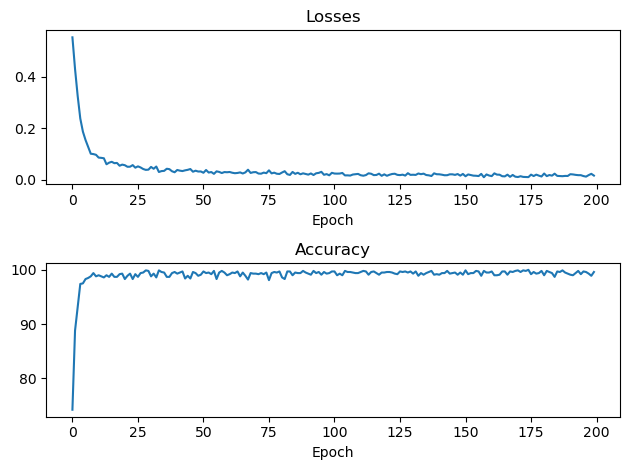

In [8]:
plt.figure()
plt.subplot(211)
plt.plot(losses)
plt.title("Losses")
plt.xlabel("Epoch")
plt.subplot(212)
plt.plot(np.array(accuracy)*100)
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.tight_layout()

## Plot the model on a grid

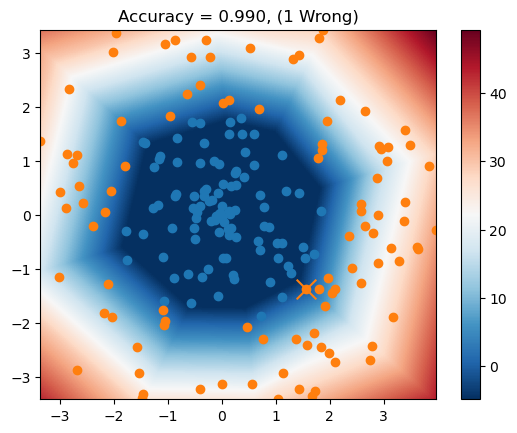

In [17]:
X0 = []
X1 = []
for i in range(200):
    x, y = data[i]
    x = x.detach().cpu().numpy()
    if y == 0:
        X0.append(x)
    else:
        X1.append(x)
X0 = np.array(X0)
X1 = np.array(X1)

def plot_model_predictions(X0, X1, model):
    X = np.concatenate((X0, X1), axis=0)
    xmin = np.min(X, axis=0)
    xmax = np.max(X, axis=0)
    iv = max(xmax[1]-xmin[1], xmax[0]-xmin[0])
    
    resol = 200
    mx = 2
    xx = np.linspace(xmin[0], xmax[0], resol)
    yy = np.linspace(xmin[1], xmax[1], resol)
    xx, yy = np.meshgrid(xx, yy)
    X = np.array([xx.flatten(), yy.flatten()], dtype=np.float32).T
    X = torch.from_numpy(X).to(device)
    Z = model(X)
    Z = Z.detach().cpu().numpy()
    Z = np.reshape(Z, xx.shape)
    plt.imshow(Z, extent=(xmin[0], xmax[0], xmax[1], xmin[1]), cmap='RdBu_r')#, vmin=0, vmax=1)
    plt.colorbar()
    
    res0 = model(torch.from_numpy(X0).to(device)).detach().cpu().numpy().flatten()
    res1 = model(torch.from_numpy(X1).to(device)).detach().cpu().numpy().flatten()
    wrong0 = res0 > 0
    wrong1 = res1 <= 0
    
    plt.scatter(X0[:, 0], X0[:, 1])
    plt.scatter(X1[:, 0], X1[:, 1])
    plt.scatter(X0[wrong0 == 1, 0], X0[wrong0 == 1, 1], s=200, marker='x', c='C0')
    plt.scatter(X1[wrong1 == 1, 0], X1[wrong1 == 1, 1], s=200, marker='x', c='C1')
    
    wrong = np.sum(wrong0) + np.sum(wrong1)
    
    plt.xlim(xmin[0], xmax[0])
    plt.ylim(xmin[1], xmax[1])
    N = X0.shape[0] + X1.shape[1]
    plt.title("Accuracy = {:.3f}, ({} Wrong)".format((N-wrong)/N, wrong))
    return Z

Z = plot_model_predictions(X0, X1, model)